## import & utils


In [1]:
from collections import namedtuple
from functools import partial
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from types import SimpleNamespace as Bunch
from IPython.display import clear_output, Image
import plotly.graph_objects as go
from ipywidgets import interact
from tqdm.auto import tqdm, trange
import jraph

pl.style.use("dark_background")


def np2pil(a):
    a = np.asarray(a)
    if a.dtype.kind == "f":
        a = np.uint8(a.clip(0, 1) * 255)
    return PIL.Image.fromarray(a)


def imshow(a):
    display(np2pil(a))


def zoom(a, k=2):
    return np.repeat(np.repeat(a, k, 1), k, 0)


def tile2d(a, w=None):
    a = np.asarray(a)
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    th, tw = a.shape[1:3]
    pad = (w - len(a)) % w
    a = np.pad(a, [(0, pad)] + [(0, 0)] * (a.ndim - 1), "constant")
    h = len(a) // w
    a = a.reshape([h, w] + list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th * h, tw * w] + list(a.shape[4:]))
    return a

In [2]:
2**8

256

In [3]:
import jax
import jax.numpy as jp
import optax
from flax import nnx

In [4]:
%load_ext autoreload
%autoreload 2

## Params

In [5]:
from boolean_nca_cc.circuits.model import generate_layer_sizes

In [6]:
input_n, output_n = 4, 4
arity = 2
layer_sizes = generate_layer_sizes(input_n, output_n, arity, layer_n=4)
loss_type = "l4"

In [7]:
layer_sizes

[(4, 1), (16, 2), (16, 2), (16, 2), (8, 1), (4, 1)]

## Training


### BackProp

In [8]:
from boolean_nca_cc.circuits.model import gen_circuit
from boolean_nca_cc.circuits.training import TrainState, train_step
from boolean_nca_cc.circuits.viz import evaluate_and_visualize
from boolean_nca_cc.circuits.tasks import get_task_data

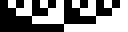

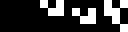

In [9]:
key = jax.random.PRNGKey(42)
wires, logitsbp = gen_circuit(key, layer_sizes, arity=arity)

opt = optax.adamw(1, 0.8, 0.8, weight_decay=1e-1)
state = TrainState(params=logitsbp, opt_state=opt.init(logitsbp))


case_n = 1 << input_n
x = jp.arange(case_n)
x, y0 = get_task_data(
    "binary_multiply", case_n, input_bits=input_n, output_bits=output_n
)

zoom_factor = 8
imshow(zoom(x.T, zoom_factor))
imshow(zoom(y0.T, zoom_factor))

In [10]:
loss_log_bp = []
aux_log_bp = []

In [11]:
pbar = trange(100)
for i in pbar:
    loss, aux, state = train_step(state, opt, wires, x, y0, loss_type, do_train=True)
    loss_log_bp.append(loss)
    aux_log_bp.append(aux)
    pbar.set_postfix_str(
        f"loss: {loss.item():.3E}, accuracy: {aux['accuracy'].item():.2%}"
        + (
            f" | hard_loss: {aux['hard_loss'].item():.3E}, hard_accuracy: {aux['hard_accuracy'].item():.2%}"
            if "hard_loss" in aux
            else ""
        )
    )

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
%timeit train_step(state, opt, wires, x, y0, loss_type, do_train=True)

5.22 ms ± 83.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


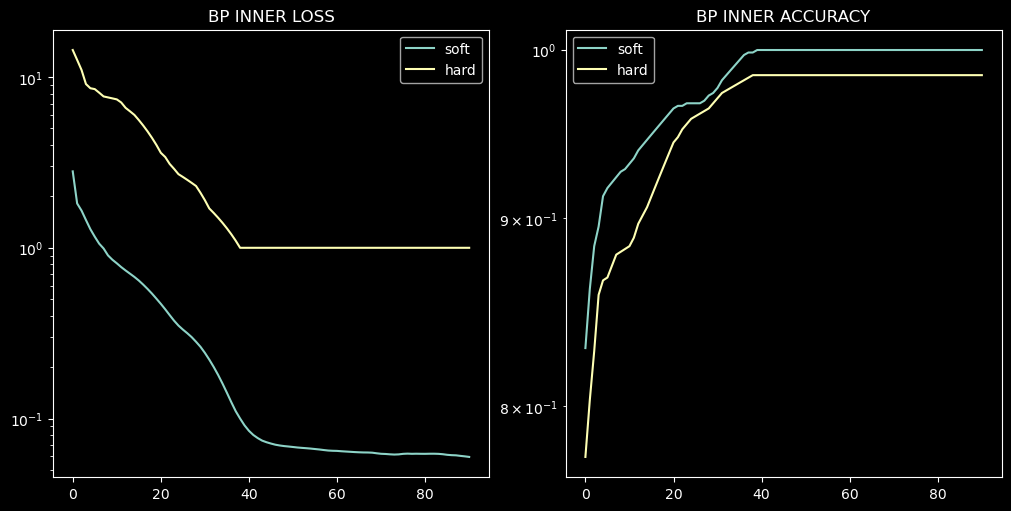

In [13]:
def plot_losses(
    loss_log, aux_log, figax=None, title=None, plot_accuracy=False, plot_hard=True
):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    v = len(loss_log) // 10

    if not plot_accuracy:
        smooth_losses = np.convolve(loss_log, np.ones(v) / v, mode="valid")
        hard_losses = [aux["hard_loss"] for aux in aux_log]
        smooth_hard_losses = np.convolve(hard_losses, np.ones(v) / v, mode="valid")
        ax.plot(smooth_losses, label="soft")
        if plot_hard:
            ax.plot(jp.maximum(smooth_hard_losses, 1e-5), label="hard")
    else:
        accs = [aux["accuracy"] for aux in aux_log]
        smooth_accs = np.convolve(accs, np.ones(v) / v, mode="valid")
        ax.plot(smooth_accs, label="soft")
        hard_accs = [aux["hard_accuracy"] for aux in aux_log]
        smooth_hard_accs = np.convolve(hard_accs, np.ones(v) / v, mode="valid")
        if plot_hard:
            ax.plot(smooth_hard_accs, label="hard")

    ax.legend()
    ax.set_yscale("log")

    if title is not None:
        ax.set_title(title)


fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True
)
plot_losses(loss_log_bp, aux_log_bp, (fig, axs[0]), title="BP INNER LOSS")
plot_losses(
    loss_log_bp,
    aux_log_bp,
    (fig, axs[1]),
    plot_accuracy=True,
    title="BP INNER ACCURACY",
)

In [14]:
bp_results = {
    "losses": loss_log_bp,
    "aux_log": aux_log_bp,
}

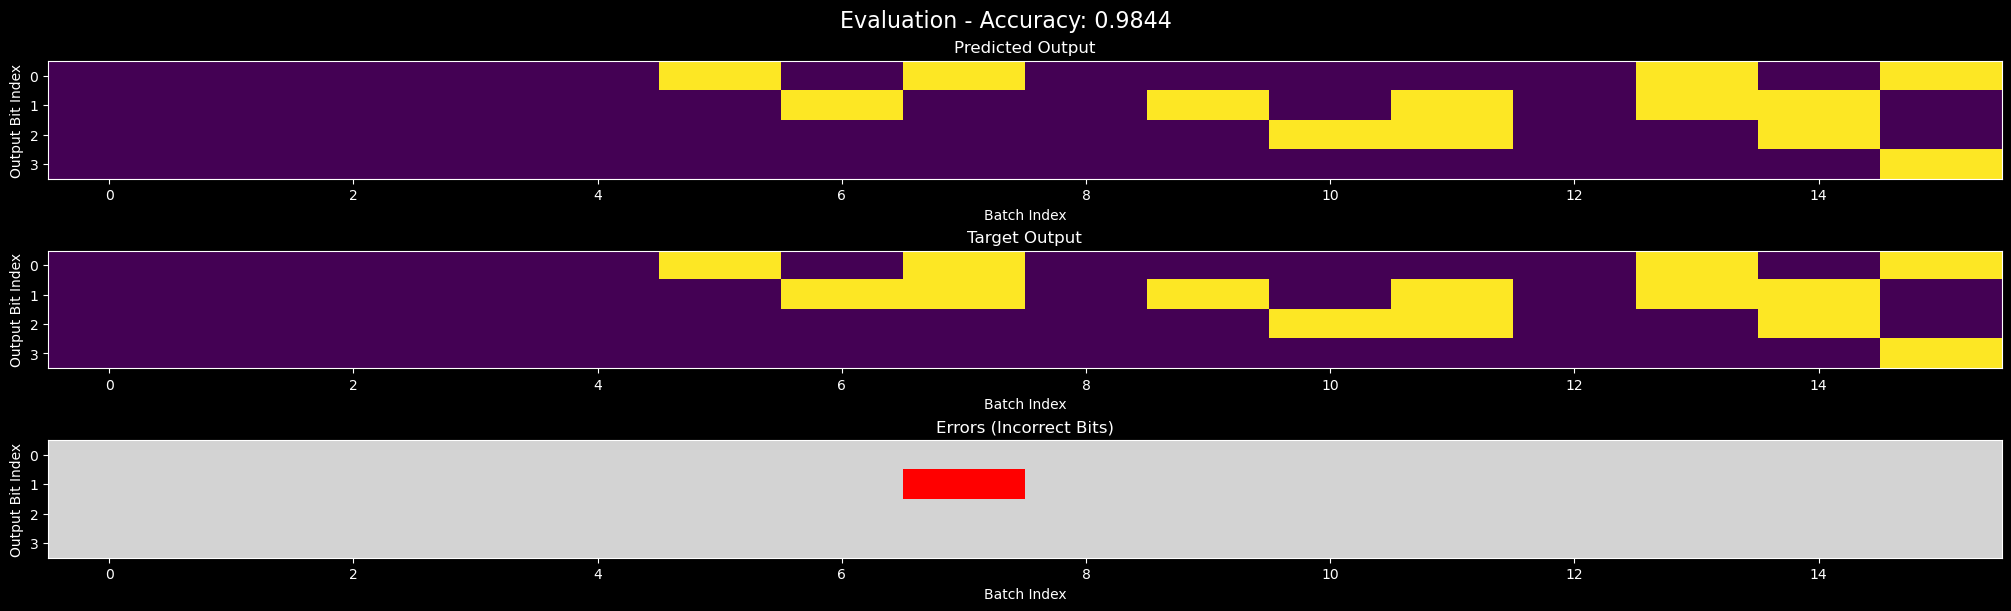

In [15]:
metrics = evaluate_and_visualize(state.params, wires, x, y0, hard=True)

In [16]:
from boolean_nca_cc.utils import build_graph, extract_logits_from_graph
from boolean_nca_cc.circuits.training import loss_f_l4

### GNN

In [17]:
from boolean_nca_cc.models import CircuitGNN, run_gnn_scan
from boolean_nca_cc.training import train_gnn

In [84]:
hidden_dim = 64
hidden_features = 64
n_message_steps = 100
loss, aux = loss_f_l4(logitsbp, wires, x, y0)
graph = build_graph(
    logitsbp, wires, input_n, arity, hidden_dim=hidden_dim, loss_value=loss
)
gnn = CircuitGNN(
    hidden_dim=hidden_dim,
    message_passing=True,
    node_mlp_features=[hidden_features, hidden_features],
    edge_mlp_features=[hidden_features, hidden_features],
    rngs=nnx.Rngs(params=jax.random.PRNGKey(42)),
    use_attention=False,
    arity=arity,
)

opt_fn = optax.adamw(1e-3, weight_decay=1e-5)
opt = nnx.Optimizer(gnn, opt_fn)

### No-Pool

In [85]:
def loss_fn(gnn: CircuitGNN, graph: jraph.GraphsTuple):
    updated_graph = run_gnn_scan(gnn, graph, n_message_steps)
    updated_logits = extract_logits_from_graph(
        updated_graph, [l.shape for l in logitsbp]
    )
    loss, aux = loss_f_l4(updated_logits, wires, x, y0)
    return loss, (*aux, updated_graph)

In [86]:
(loss, aux), grads = nnx.value_and_grad(loss_fn, has_aux=True)(gnn, graph)

In [87]:
loss

Array(9.389708, dtype=float32)

In [88]:
aux[-1].nodes["logits"].mean()

Array(0., dtype=float32)

In [89]:
(loss, aux), grads = nnx.value_and_grad(loss_fn, has_aux=True)(gnn, graph)
opt.update(grads)
(loss, aux), grads = nnx.value_and_grad(loss_fn, has_aux=True)(gnn, graph)
assert any(jax.tree.leaves(jax.tree.map(lambda x: x.any(), grads))), "No grads"

In [90]:
gnn_results = train_gnn(
    # CIRCUIT PARAMS
    layer_sizes=layer_sizes,
    x_data=x,
    y_data=y0,
    arity=arity,
    # TRAINING PARAMS
    epochs=2**13,
    # epochs=1,
    n_message_steps=n_message_steps,
    key=42,
    meta_batch_size=16,
    lr_scheduler="cosine",
    loss_type="l4",
    meta_learning=True,
    # INITIAL GNN AND OPTIMIZER
    hidden_dim=hidden_dim,
    init_gnn=gnn,
    init_optimizer=opt,
)

Training GNN:   0%|          | 0/8192 [00:00<?, ?it/s]

: 

In [77]:
try:
    gnn_results["gnn"] = nnx.state(gnn_results["gnn"])
    gnn_results["optimizer"] = nnx.state(gnn_results["optimizer"])
except ValueError:
    print("already converted")
    pass

already converted


In [78]:
# save gnn_results
import pickle

with open("gnn_results.pkl", "wb") as f:
    pickle.dump(gnn_results, f)

In [79]:
# recreate aux in old format
aux_log = [
    {
        "accuracy": accuracies,
        "hard_accuracy": hard_acc,
        "hard_loss": hard_loss,
    }
    for accuracies, hard_acc, hard_loss in zip(
        gnn_results["accuracies"],
        gnn_results["hard_accuracies"],
        gnn_results["hard_losses"],
    )
]

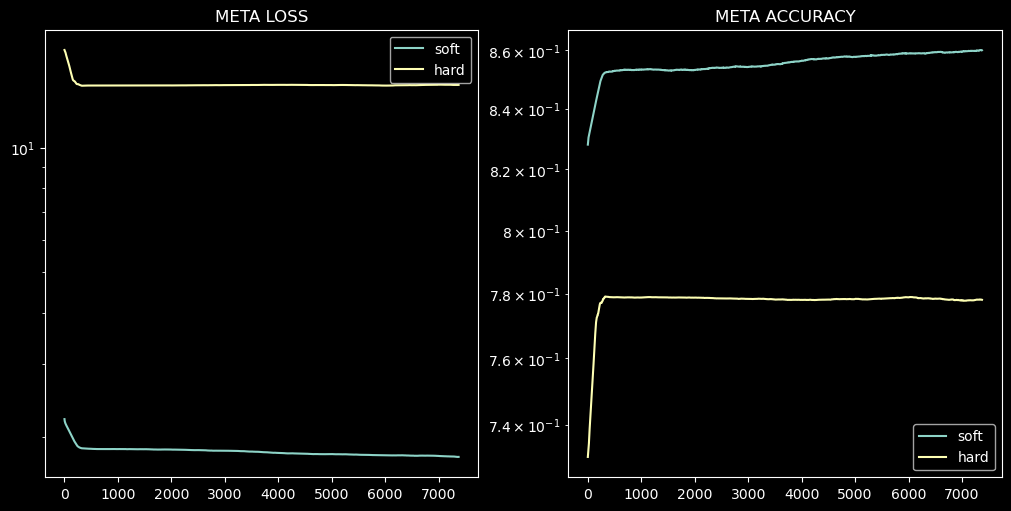

In [80]:
fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True
)
plot_losses(
    gnn_results["losses"], aux_log, (fig, axs[0]), title="META LOSS", plot_hard=True
)
plot_losses(
    gnn_results["losses"],
    aux_log,
    (fig, axs[1]),
    plot_accuracy=True,
    title="META ACCURACY",
    plot_hard=True,
)

In [81]:
# Get the inner loop losses
from boolean_nca_cc.training.evaluation import evaluate_gnn_stepwise

In [82]:
nnx.update(gnn, gnn_results["gnn"])

In [83]:
key = jax.random.PRNGKey(42)
wires_gnn, logits_gnn = gen_circuit(key, layer_sizes, arity=arity)
step_metrics = evaluate_gnn_stepwise(
    gnn,
    wires_gnn,
    logits_gnn,
    x,
    y0,
    input_n,
    n_message_steps=100,
    arity=arity,
    hidden_dim=hidden_dim,
    loss_type="l4",
)

Evaluating GNN steps:   0%|          | 0/100 [00:00<?, ?it/s]

-0.11466086
-0.16205382
-0.17387068
-0.18471539
-0.19702125
-0.20879531
-0.21446037
-0.2139554
-0.20525646
-0.18370056
-0.1453414
-0.088989735
-0.010434151
0.09693575
0.24243593
0.43826127
0.701077
1.0532703
1.524188
2.1532102
2.9909968
4.103613
5.5813794
7.548017
10.162318
13.638605
18.26716
24.42633
32.625957
43.546814
58.088806
77.45026
103.23226
137.57217
183.28859
244.1629
325.25256
433.22958
577.0128
768.54785
1023.4748
1363.0035
1815.095
2417.0747
3218.474
4285.606
5706.3623
7598.331
10117.999
13472.863
17939.227
23886.05
31804.861
42347.75
56386.17
75073.97
99959.59
133096.16
177219.5
235959.34
314189.38
418324.66
556965.1
741620.5
987426.44
1314753.8
1750447.5
2330613.2
3103068.8
4132041.0
5501798.0
7325404.0
9752060.0
12982509.0
17283374.0
23009794.0
30634294.0
40784800.0
54301330.0
72288790.0
96242350.0
128132180.0
170595170.0
227114370.0
302361400.0
402547600.0
535929100.0
713429000.0
949784960.0
1264401400.0
1683361800.0
2241060900.0
2983412200.0
3971431400.0
5287393300.0


In [ ]:
step_metrics.edges

In [37]:
aux_log_stepwise = [
    {"accuracy": acc, "hard_accuracy": hard_acc, "hard_loss": hard_loss}
    for acc, hard_acc, hard_loss in zip(
        step_metrics["soft_accuracy"],
        step_metrics["hard_accuracy"],
        step_metrics["hard_loss"],
    )
]

In [35]:
step_metrics.keys()

dict_keys(['step', 'soft_loss', 'hard_loss', 'soft_accuracy', 'hard_accuracy'])

In [38]:
gnn_log_results = {
    "losses": step_metrics["soft_loss"],
    "aux_log": aux_log_stepwise,
}

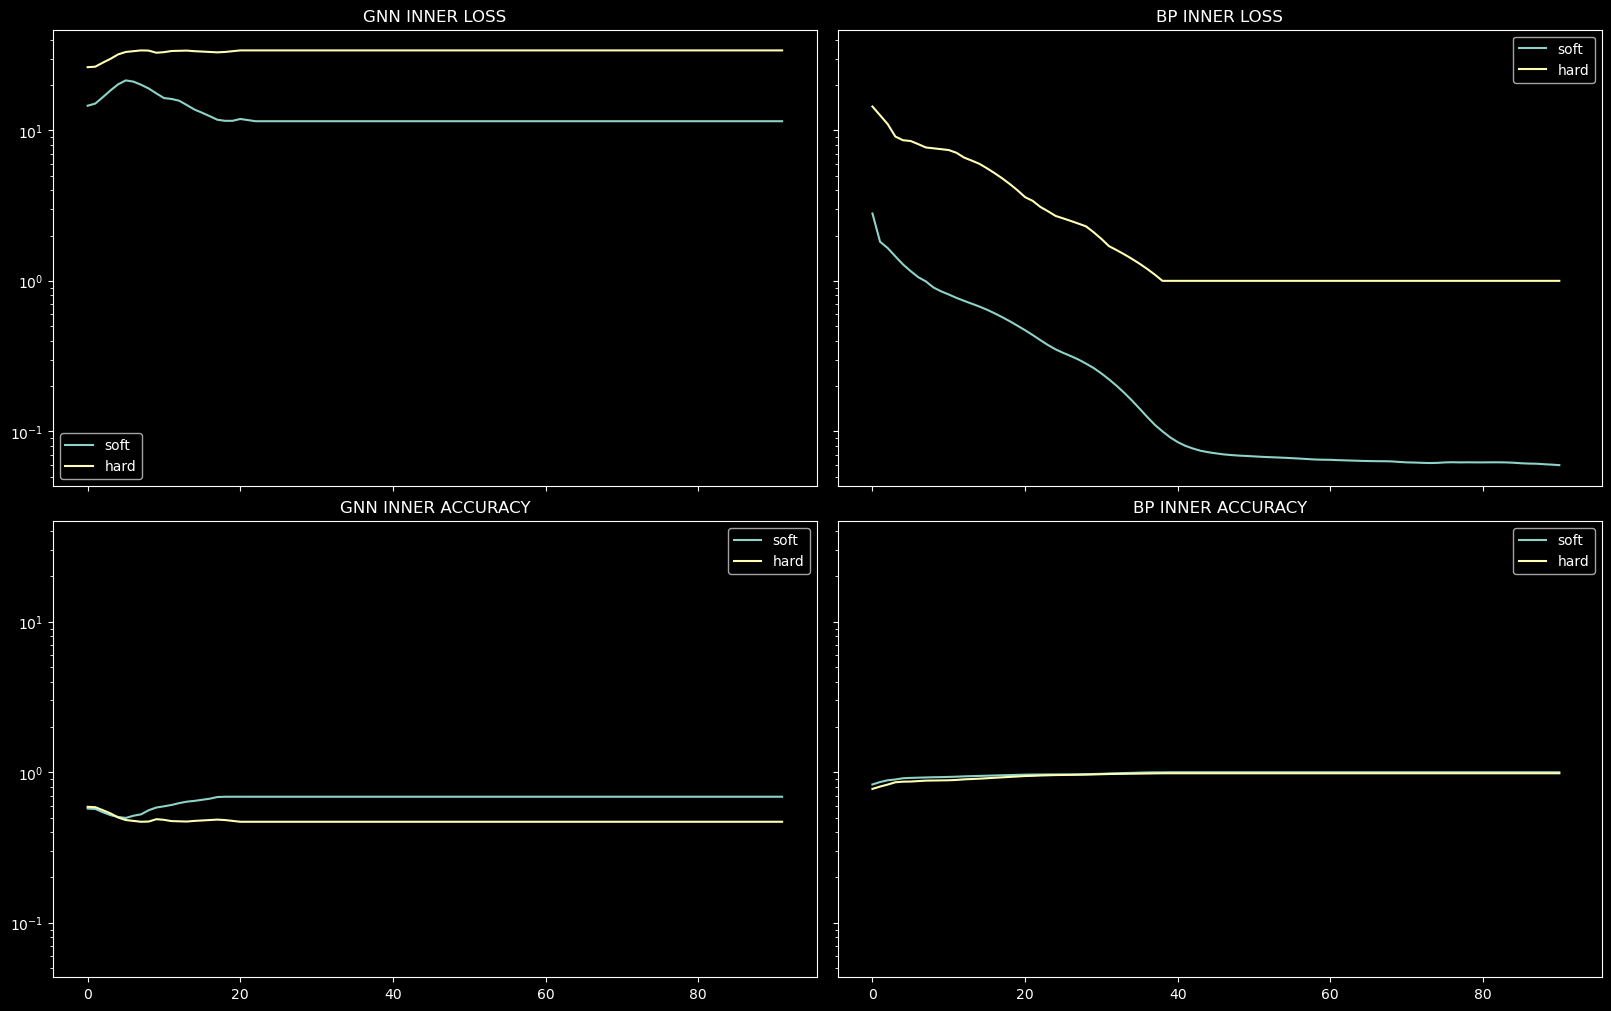

In [ ]:
# Compare GNN and BP

fig, axs = plt.subplots(
    2, 2, figsize=(16, 10), sharey=True, sharex=True, constrained_layout=True
)

for method, axs_method, results in zip(
    ["GNN", "BP"], axs.T, [gnn_log_results, bp_results]
):
    for metric, ax in zip(["loss", "accuracy"], axs_method):
        if metric == "loss":
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER LOSS",
            )
        else:
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER ACCURACY",
                plot_accuracy=True,
            )

### Pool

In [187]:
from boolean_nca_cc.training.pool_train_loop import train_gnn_with_pool

In [ ]:
train_gnn_with_pool(
    layer_sizes=layer_sizes,
    x_data=x,
    y_data=y0,
    arity=arity,
    hidden_dim=hidden_dim,
    message_passing=True,
    node_mlp_features=[hidden_features, hidden_features],
    edge_mlp_features=[hidden_features, hidden_features],
    use_attention=True,
    learning_rate=1e-3,
    epochs=2**15,
    n_message_steps=n_message_steps,
    key=42,
    weight_decay=1e-5,
    pool_size=1024,
    reset_fraction=0.5,
    perturb_fraction=0.3,
    batch_size=64,
    init_gnn=gnn,
    init_optimizer=opt,
    initial_metrics=None,
    lr_scheduler="cosine",
    lr_scheduler_params=None,
    loss_type="bce",
)

Training GNN with Pool:   0%|          | 0/32768 [00:00<?, ?it/s]

ValueError: Dict key mismatch; expected keys: ['logits', 'wires']; dict: {'logits': [Traced<ShapedArray(float32[64,8,2,4])>with<DynamicJaxprTrace(level=2/0)>, Traced<ShapedArray(float32[64,8,2,4])>with<DynamicJaxprTrace(level=2/0)>, Traced<ShapedArray(float32[64,8,2,4])>with<DynamicJaxprTrace(level=2/0)>, Traced<ShapedArray(float32[64,8,1,4])>with<DynamicJaxprTrace(level=2/0)>, Traced<ShapedArray(float32[64,4,1,4])>with<DynamicJaxprTrace(level=2/0)>]}.

## Attention

In [156]:
from boolean_nca_cc.models.self_attention import (
    CircuitSelfAttention,
    run_self_attention_scan,
)
from boolean_nca_cc.training import train_self_attention

In [19]:
hidden_dim = 64
hidden_features = 64
n_message_steps = 100
graph = build_graph(logitsbp, wires, input_n, arity, hidden_dim=hidden_dim)

In [30]:
circuit_attention = CircuitSelfAttention(
    hidden_dim=hidden_dim,
    num_heads=4,
    num_layers=2,
    arity=arity,
    dropout_rate=0.1,
    rngs=nnx.Rngs(params=jax.random.PRNGKey(42)),
    n_node=int(graph.n_node[0]),
)

opt_fn = optax.adamw(1e-3, weight_decay=1e-5)
opt = nnx.Optimizer(circuit_attention, opt_fn)

In [ ]:
updated_graph = circuit_attention(graph)

updated_graph = run_self_attention_scan(circuit_attention, graph, n_message_steps)

(1, 232, 16) 0.0 0.0 0.0
(1, 232, 16) Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>


In [24]:
def loss_fn_att(gnn: CircuitSelfAttention, graph: jraph.GraphsTuple):
    updated_graph = run_self_attention_scan(gnn, graph, n_message_steps)

    updated_logits = extract_logits_from_graph(
        updated_graph, [l.shape for l in logitsbp]
    )
    return loss_f_l4(updated_logits, wires, x, y0)

In [25]:
loss, aux = loss_fn_att(circuit_attention, graph)

In [26]:
(loss, aux), grads = nnx.value_and_grad(loss_fn_att, has_aux=True)(
    circuit_attention, graph
)

In [ ]:
attn_results = train_self_attention(
    x_data=x,
    y_data=y0,
    layer_sizes=layer_sizes,
    arity=arity,
    hidden_dim=hidden_dim,
    num_heads=4,
    num_layers=2,
    mlp_dim=64,
    learning_rate=1e-3,
    epochs=2**15,
    n_attention_steps=n_message_steps,
    key=42,
    weight_decay=1e-5,
    dropout_rate=0,
    meta_learning=True,
    meta_batch_size=16,
    init_model=circuit_attention,
    init_optimizer=opt,
    initial_metrics=None,
    lr_scheduler="cosine",
    lr_scheduler_params=None,
)

Training Self-Attention:   0%|          | 0/32768 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
with open("attn_results.pkl", "wb") as f:
    pickle.dump(attn_results, f)